##### Visualize Mixing Depth and PAR over full hindcast <br>
G Oldford
Apr 2023

Purpose: generate climatological profile and visuals along N-S (maybe thalweg later)
         and trends of mixing layer depth and photosynthetically available radiation
         from NEMO SS1500 outputs (clipped to ECOSPACE grid)
         
Data in: ASC mixing layer depth (monthly, clipped to ECOSPACE - NC's after initial invest)

Code based on work by Tereza Jarnikova to generate the figs and analysis for temp, salin

Notes: 
- 2023-04-13 - try xr.polyval to look at strength of trend
- 2023-04-13 - issue with light averaging leading to nulls (can see in results below)
- 2023-04-05 - light in and PAR needs update from ERA5 to RDRS v21 - done
- 2023-04-03 - missing mixing data for 2018 (to-do) - done

In [1]:

import numpy as np
import xarray as xr
import pandas as pd

import cartopy as cp
import matplotlib.pyplot as plt
import cartopy
from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.patches import Rectangle
import cmocean as cm


In [2]:
## load ASC files used in ECOSPACE
## Load data as-is into xarray dataset and then row-wise avg as xr

path_data = "../data/output/RUN203/ECOSPACE/"
mxng_p = "NEMO_prepped_as_ASC/{var}/"
tmp_p = "NEMO_prepped_as_ASC/{var}/"
li_p = "ECOSPACE_in_PAR3_SalAt10m/{var}/"
k_p = "ECOSPACE_in_PAR3_SalAt10m/RUN203_{var}/"
sal_p = "NEMO_prepped_as_ASC/{var}/"

path_data2 = "../data/forcing/"
li_p2 = "light_monthly_ASC/{var}/"

# template file names w/ var names
v_f = {"MixedLyrZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc", 
       "MixingTurboZ":path_data + mxng_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "TempVertMean10m":path_data + tmp_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",  
       "PAR-VarZ-VarK":path_data + li_p + "{var}_{year}_{month}.asc",  
       "Kfromsal":path_data + k_p + "RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "SalinVertMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "zvelocMean10m":path_data + sal_p + "SalishSea1500-RUN203_{var}_{year}_{month}.asc",
       "solar_rad":path_data2 + li_p2 + "RDRS21_NEMOgrid_{var}_{year}_{month}.asc"
      }

yr_strt = 1979
yr_end = 2017
months_d = {"01": 1, "02": 2, "03": 3,"04": 4,"05": 5,"06": 6,"07": 7,"08": 8,"09": 9,"10": 10,"11": 11,"12": 12}
months = list(range(1,12))

rows = 151
cols = 93
months = 12

skiprows = 6 # header

time = pd.date_range(start='{yr_strt}-01-01'.format(yr_strt=yr_strt), 
                              end='{yr_end}-12-01'.format(yr_end=yr_end), 
                              freq='MS')+ pd.DateOffset(days=14)

# empty ds for all 
ds = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
        'col': range(1, cols+1)
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# create empty variable with correct shape
for v in v_f:
    ds[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows, cols)),
        dims=('time', 'row', 'col'),
        attrs={'description': f'{v} data'}
    )

# load the data
for v in v_f:
    attribute = v_f[v]
    for y in range(yr_strt, yr_end+1):
        for m in sorted(months_d.keys()):
            f_n = v_f[v].format(var=v,year=y,month=m)
            with open(f_n) as f:
                data = np.loadtxt(f,skiprows=skiprows)
                
                # homogenize what nans are
                data[data==-9999.0]=['nan']
                data[data==0.0]=['nan']
                
                # fix issue with bottom left area in map
                data[140:,:15]=['nan']
                
                ds[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    data,
                    dims=('row', 'col'),
                    attrs={'description': f'{v} data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )
                
# second dataset to store the row-wise averages 
ds2 = xr.Dataset(
    coords={
        'time': time,
        'row': range(1, rows+1), 
    },
    attrs={
        'description': 'Example dataset of monthly ASC files',
    }
)

# empty variable with correct shape for ds2
for v in v_f:
    ds2[v] = xr.DataArray(
        np.nan*np.zeros((len(time), rows)),
        dims=('time','row'),
        attrs={'description': f'{v} avg row-wise'}
    )
    
# Calculates row-wise averages for each attribute and each month
for v in v_f:
    for y in range(yr_strt, yr_end+1):   
        for m in sorted(months_d.keys()):
            # Select the data for this attribute and month
            data = ds[v].sel(time=f'{y}-{m}'.format(y=y,m=m))

            # Calculate the row-wise average and print it
            row_avg = data.mean(dim='col')
            
            ds2[f'{v}'.format(var=v)].loc[{'time': f'{y}-{m}-15'.format(year=y,month=m)}] = xr.DataArray(
                    row_avg[0],
                    dims=('row'),
                    attrs={'description': f'{v} avg row-wise data for year {y} month {m}'.format(var=v,year=y,month=m)}
                )


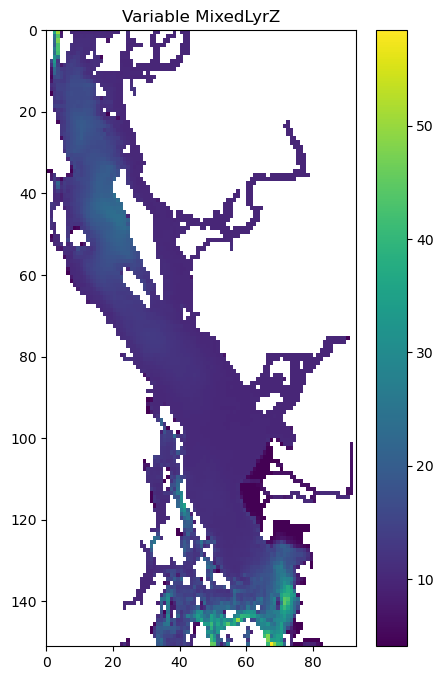

In [126]:
# test map of ECOSPACE domain by row /col (clipped from NEMO)
# note the bottom left should be fixed (nans)
fig, axs = plt.subplots(figsize = (5,8))

v = list(v_f)[0]
v1 = ds[v]
d1 =  v1[0]
    
w = plt.pcolormesh(d1)
axs.set_title('Variable {v}'.format(v=v))
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

In [92]:
ds2

<xarray.Dataset>
Dimensions:           (time: 468, row: 151)
Coordinates:
  * time              (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2017-12-15
  * row               (row) int32 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
Data variables:
    MixedLyrZ         (time, row) float64 12.81 12.37 12.82 ... 17.31 16.2 17.12
    MixingTurboZ      (time, row) float64 13.35 13.2 13.44 ... 34.03 30.28 30.38
    TempVertMean      (time, row) float64 3.32 2.487 2.758 ... 1.337 1.157 1.062
    TempVertMean10m   (time, row) float64 5.42 5.591 5.474 ... 7.726 6.957 6.992
    PAR-VarZ-VarK     (time, row) float64 5.588 5.843 5.763 ... 7.448 6.9 6.208
    Kfromsal          (time, row) float64 0.2436 0.2317 0.2542 ... 0.3123 0.3008
    SalinVertMean     (time, row) float64 11.57 8.757 9.637 ... 4.187 3.876
    SalinVertMean10m  (time, row) float64 26.92 27.12 26.76 ... 26.01 26.21
    zvelocMean10m     (time, row) float64 -0.02 -0.04375 0.3 ... 0.1571 -0.092
    solar_rad         (time, row) float64 44.65 45.0 45.11 ... 41.13 40.92 40.88
Attributes:
    description:  Example dataset of monthly ASC files

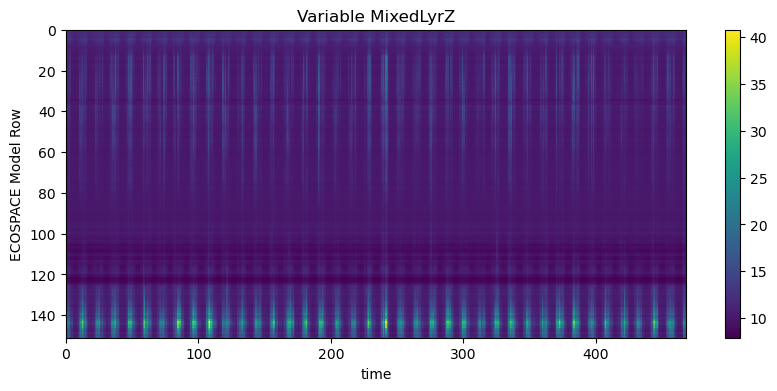

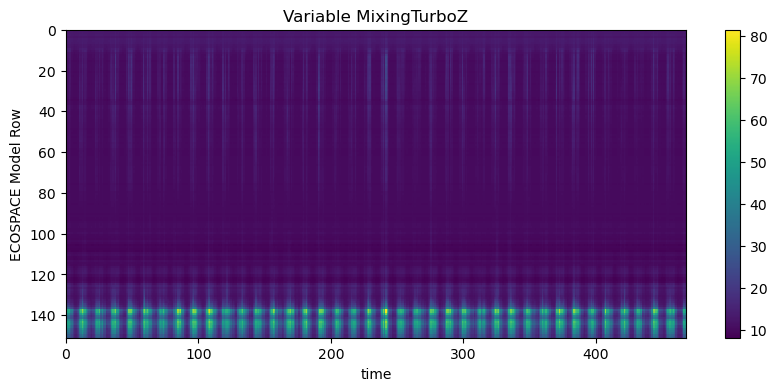

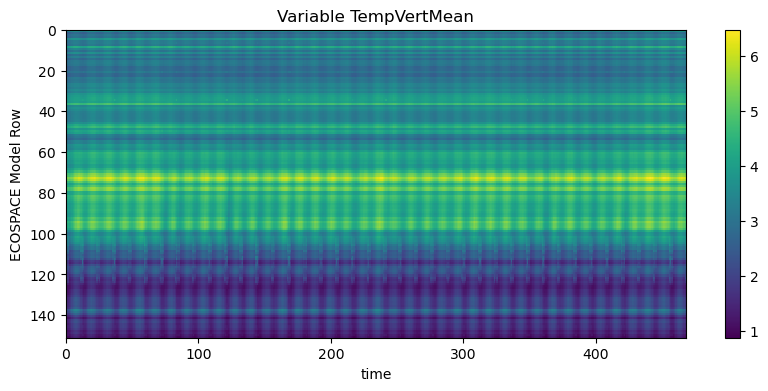

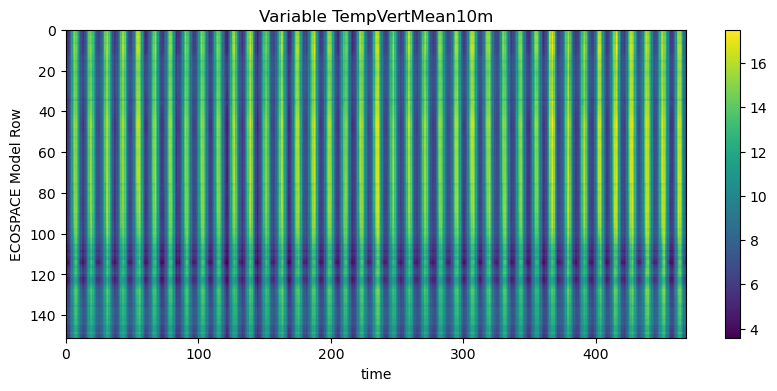

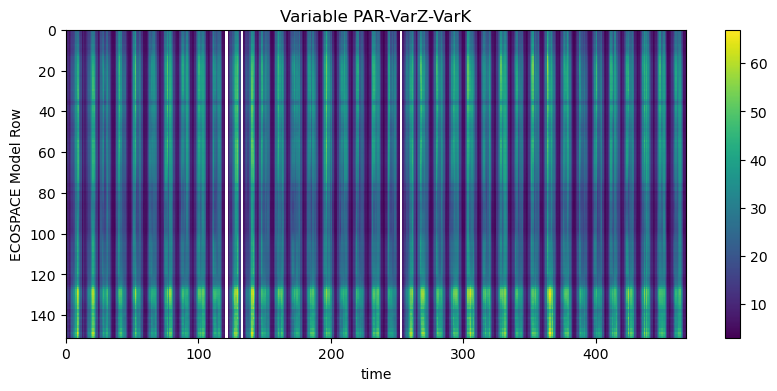

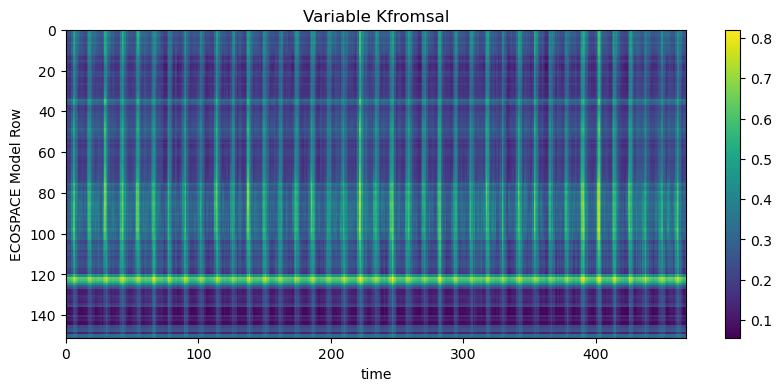

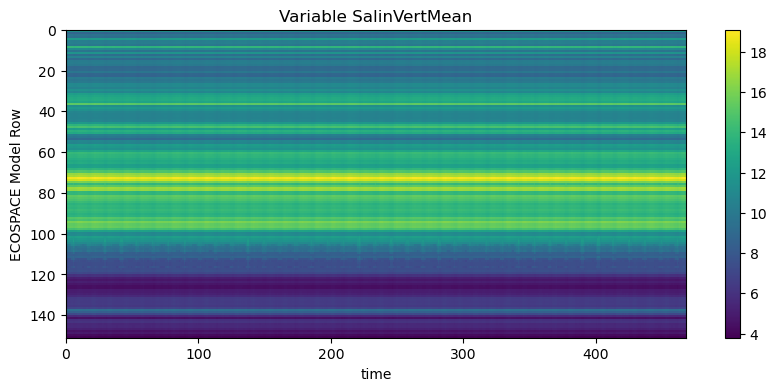

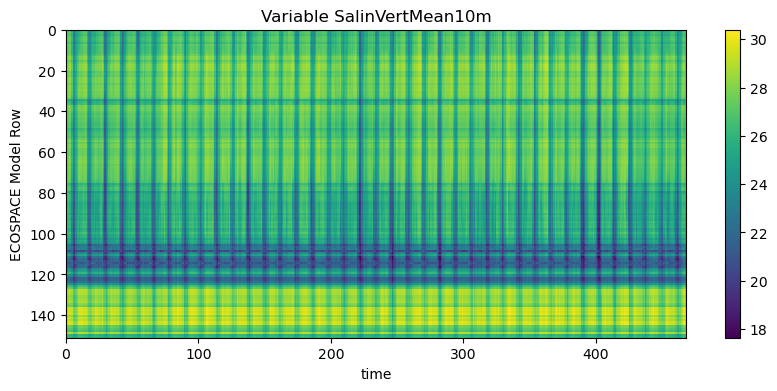

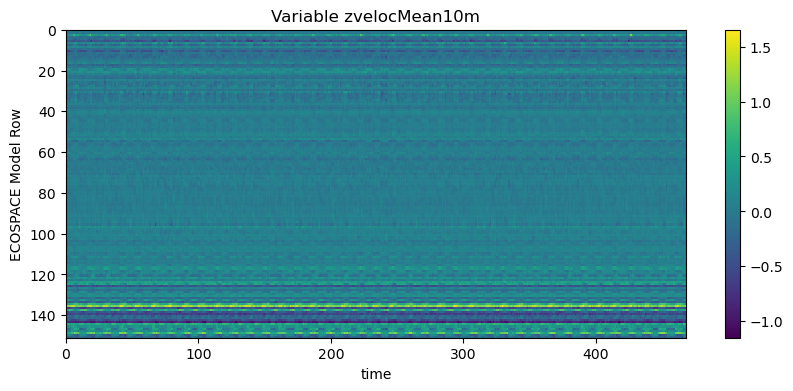

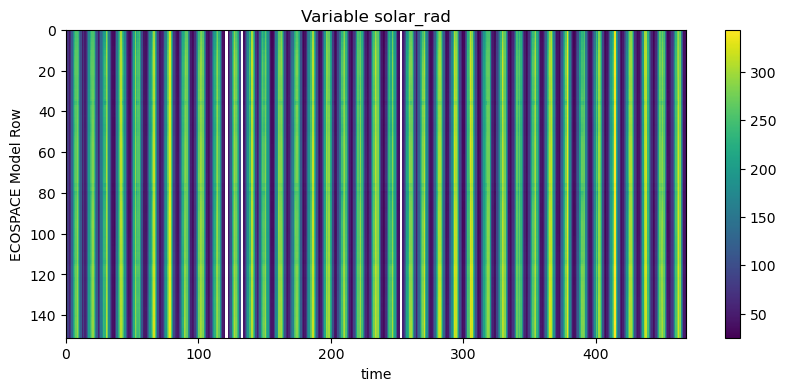

In [93]:
# check we have data, plots working
for v in v_f:
    v1 = ds2[v]
    fig, axs = plt.subplots(figsize = (10,4))
    w = plt.pcolormesh(xr.DataArray.transpose(v1))
    axs.set_title('Variable {v}'.format(v=v))
    plt.colorbar(w, ax = axs)
    axs.invert_yaxis()
    axs.set_xlabel('time')
    axs.set_ylabel('ECOSPACE Model Row')


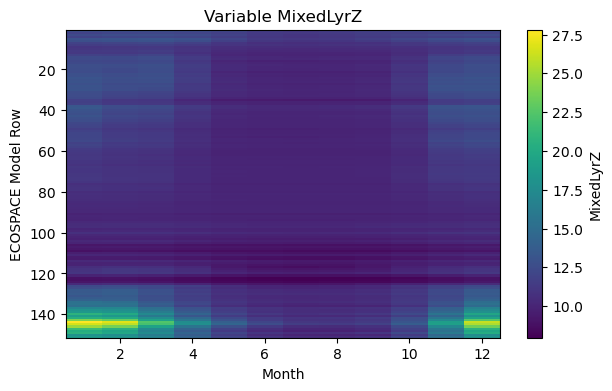

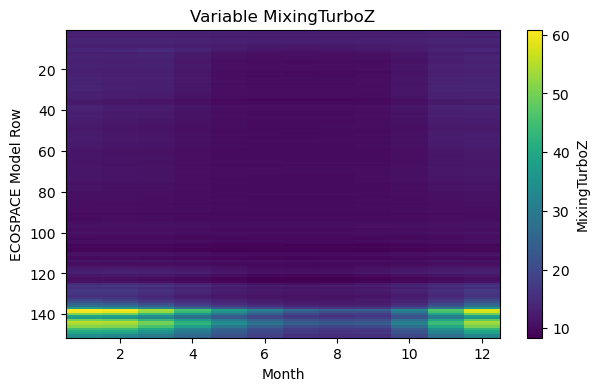

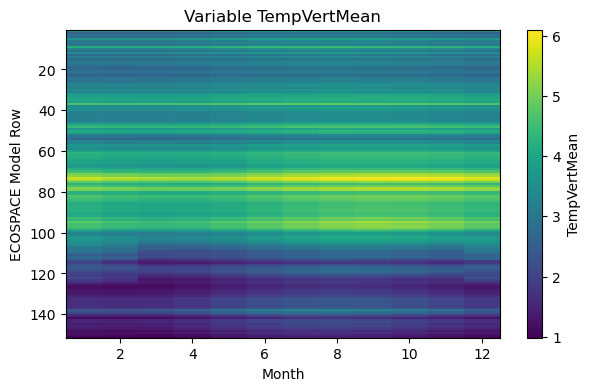

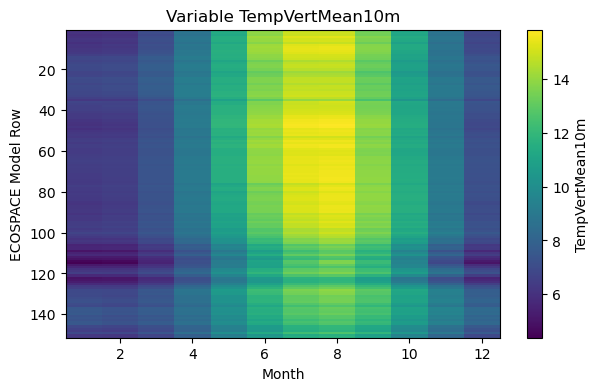

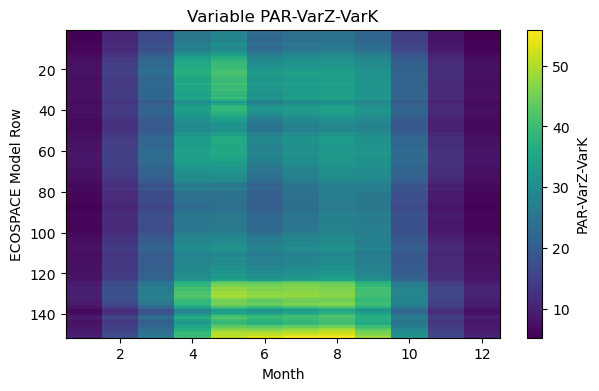

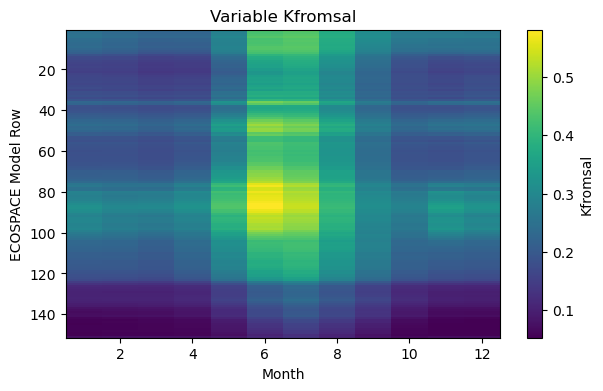

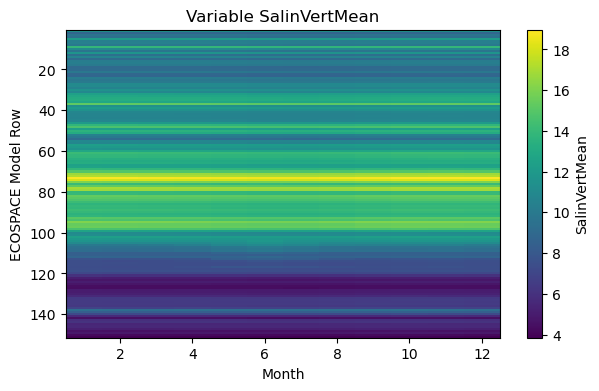

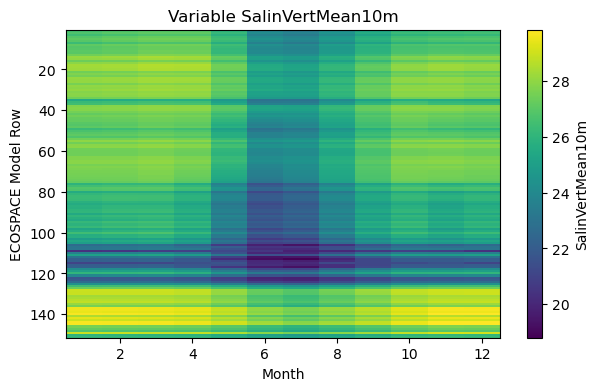

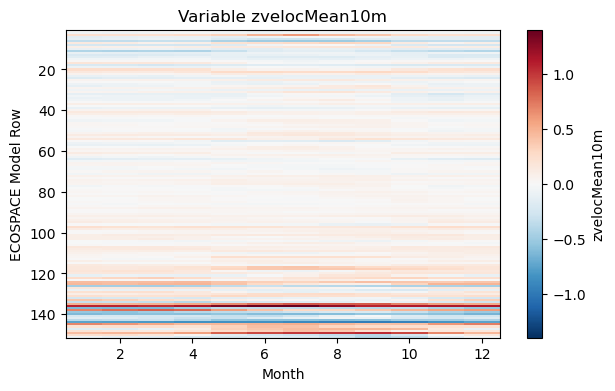

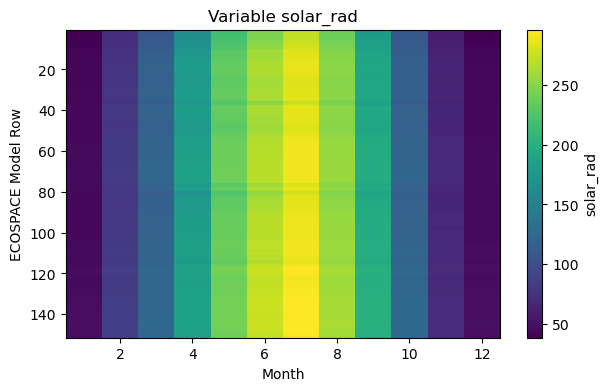

In [127]:
# climatologies

for v in v_f:
    v1 = ds2[v]
    q = v1.groupby('time.month').mean(dim='time').T
    
    fig, axs = plt.subplots(figsize = (7,4))
    xr.plot.pcolormesh(q, ax = axs)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('Month')
    axs.set_ylabel('ECOSPACE Model Row')

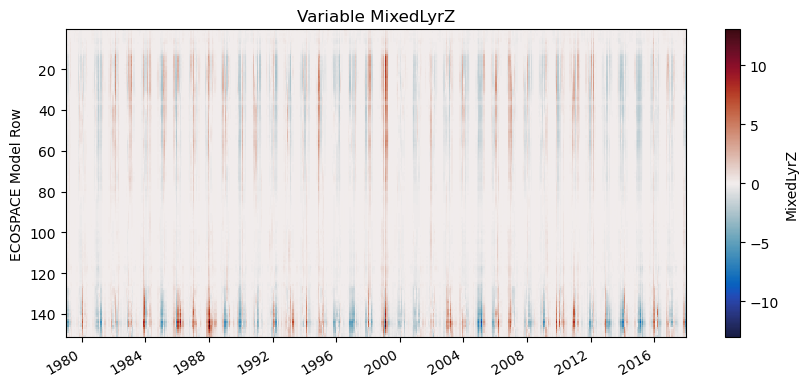

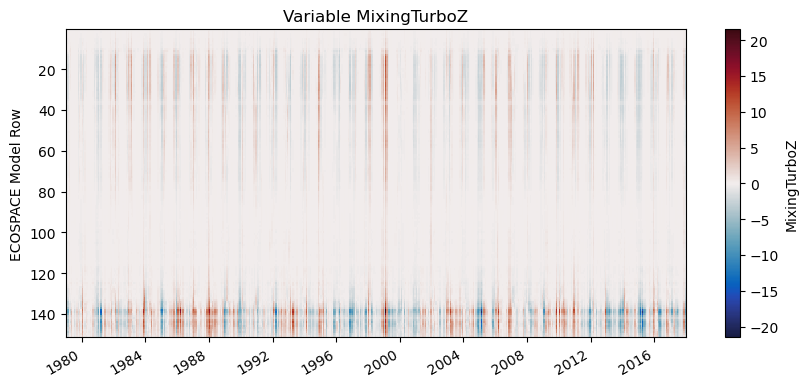

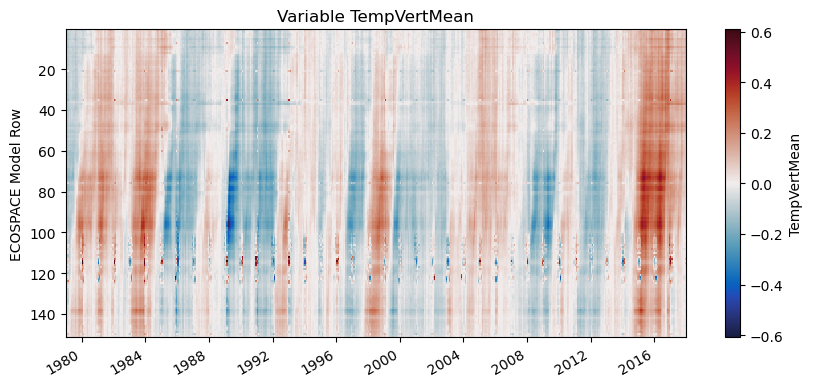

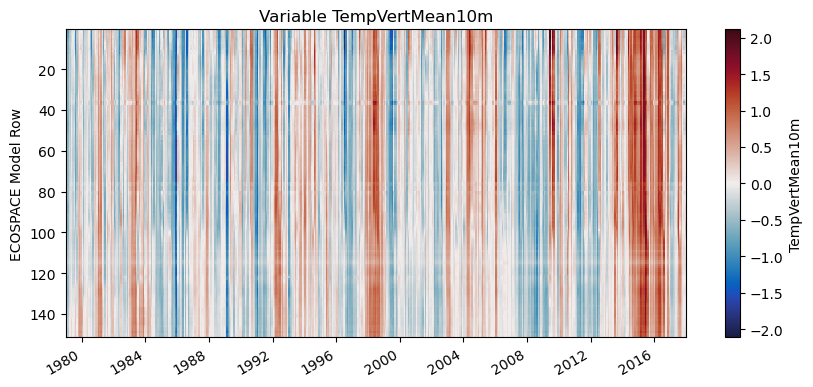

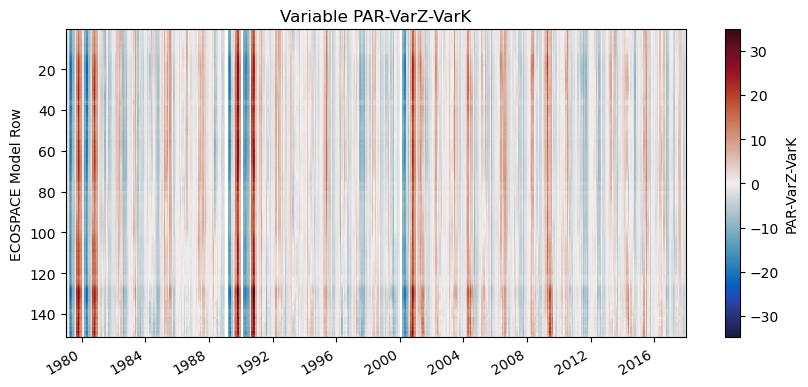

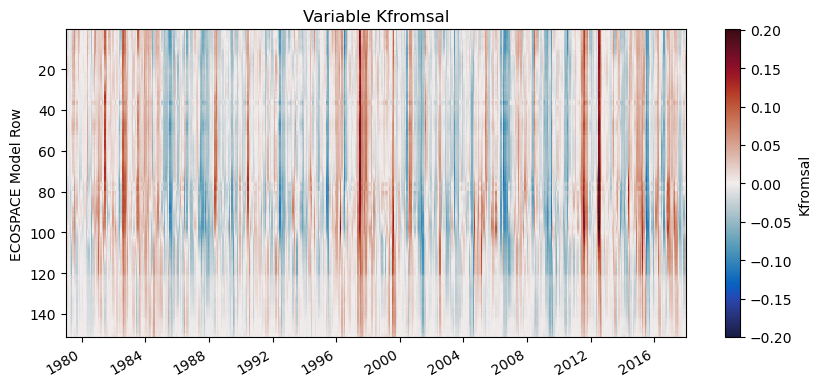

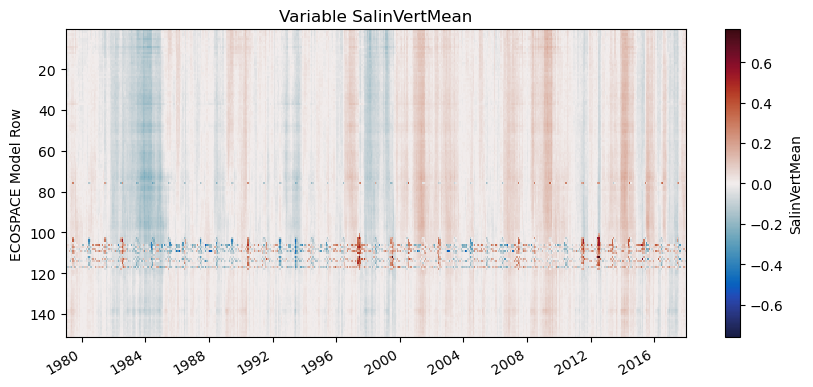

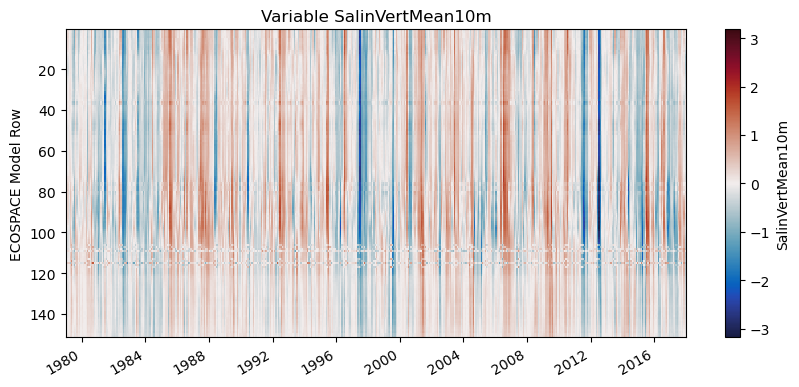

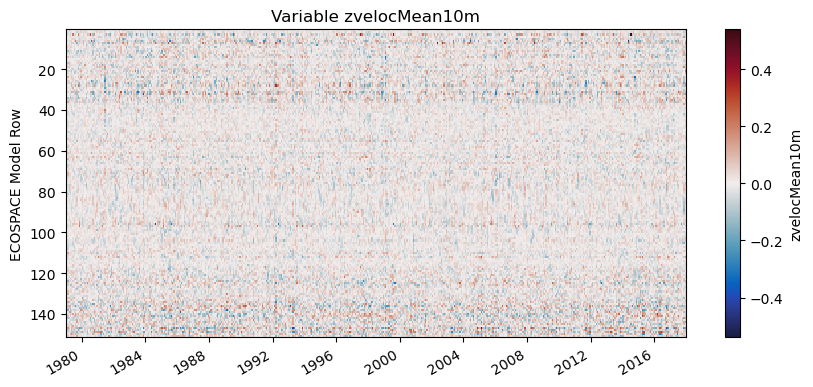

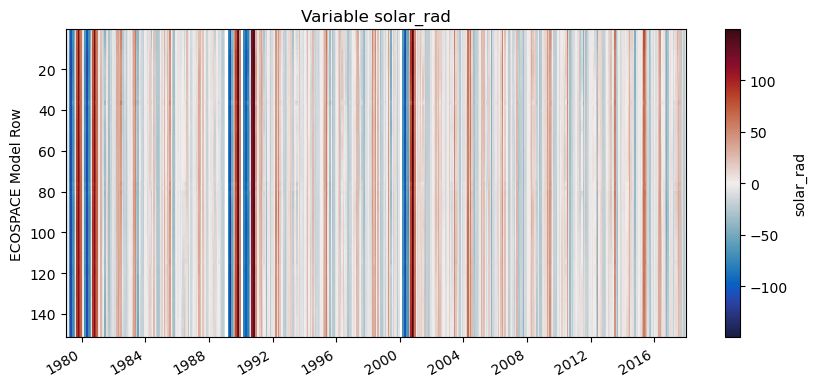

In [96]:
#var_minusclim = temp_bm.groupby(ds2.timeperiod)-temp_clim

for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    #anom =  anom.isel(row = (anom.row > 0) & (anom.row < 30)) # change rows, explore n-s trends
    
    
    fig, axs = plt.subplots(figsize = (10,4))
    xr.plot.pcolormesh(anom, ax = axs,cmap = cm.cm.balance)
    axs.set_title('Variable {v}'.format(v=v))
    #plt.colorbar(w, ax = axs)
    
    axs.invert_yaxis()
    axs.set_xlabel('')
    axs.set_ylabel('ECOSPACE Model Row')



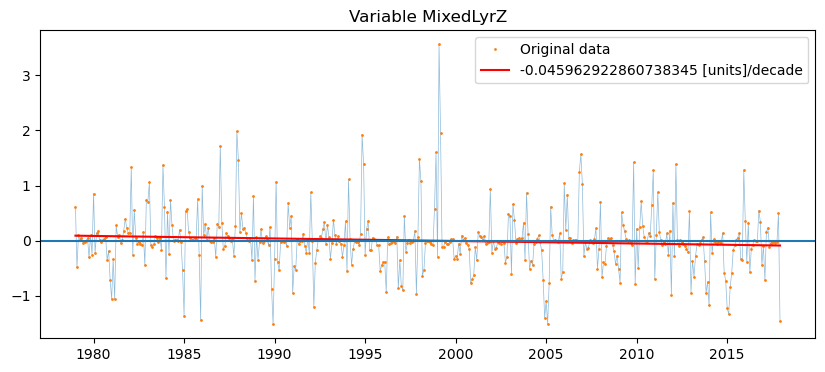

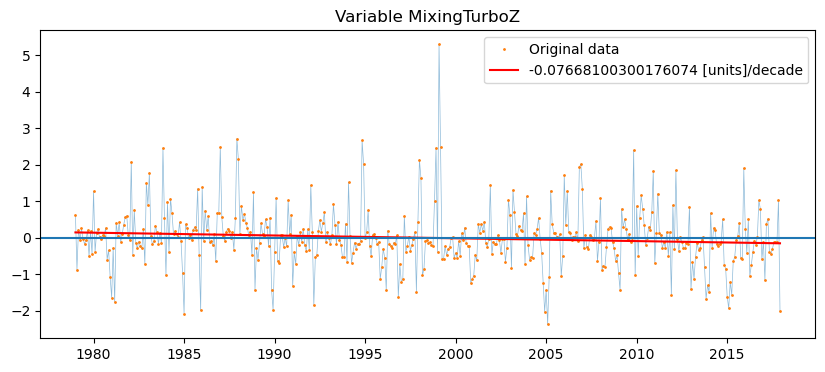

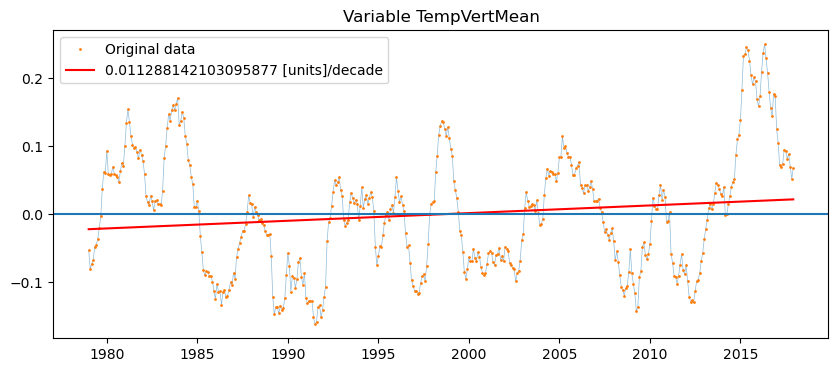

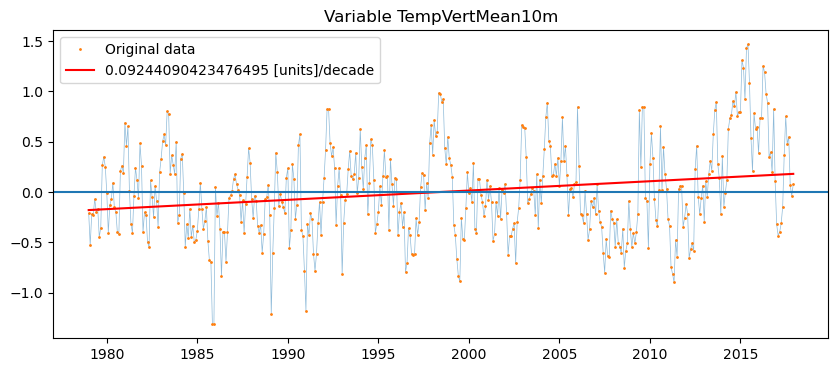

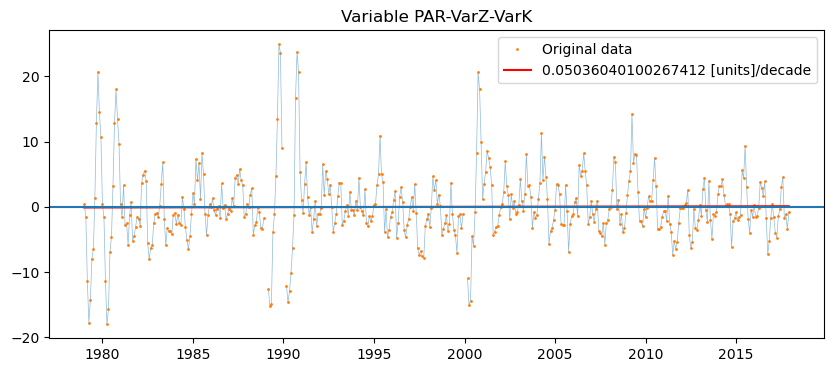

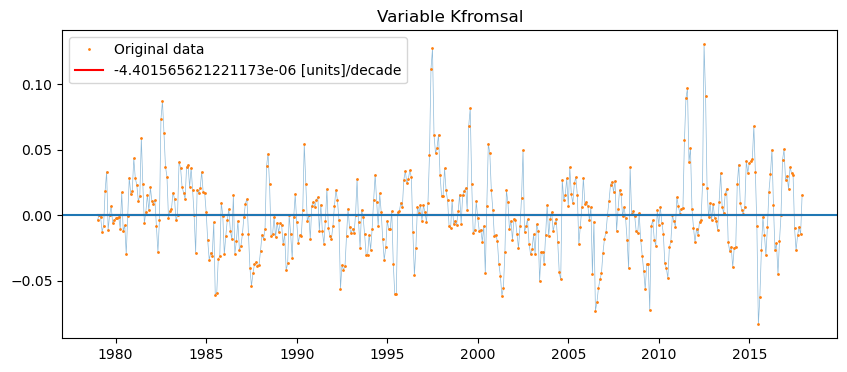

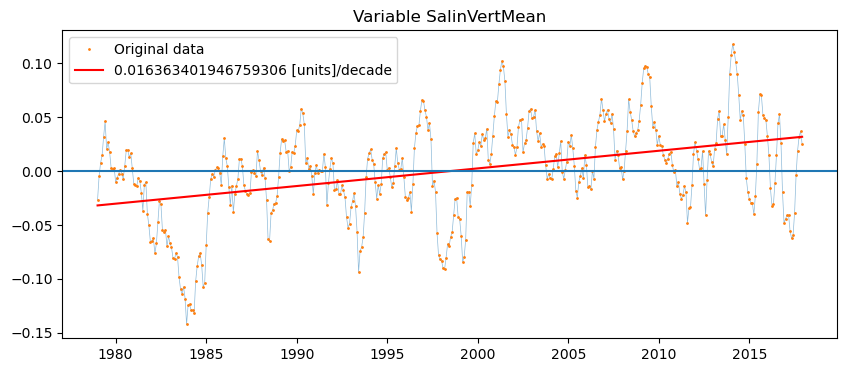

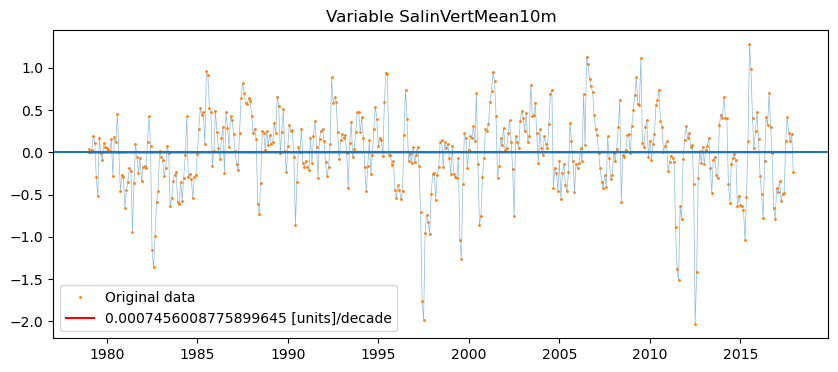

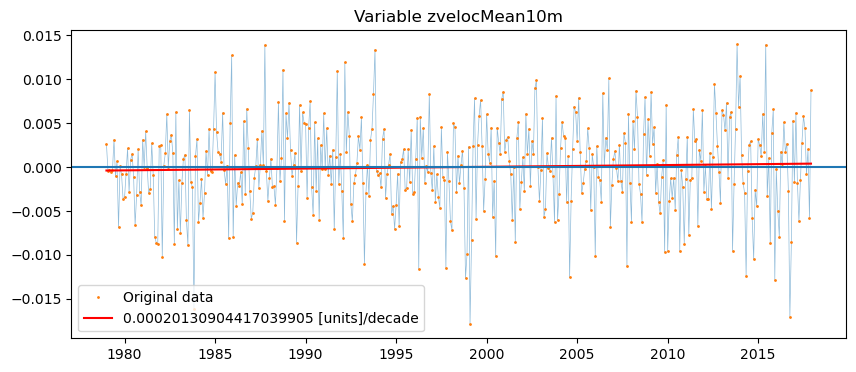

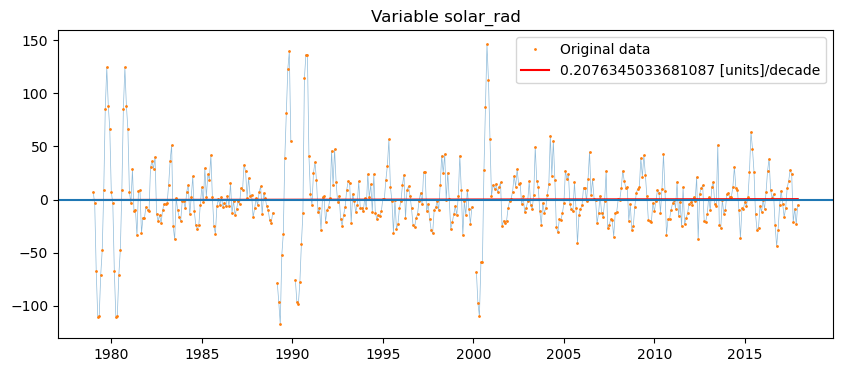

In [120]:
for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    mean_anom =  anom.isel(row = (anom.row > 0) & (anom.row < 151)).mean(dim = 'row') # change rows, explore n-s trends
    
    tyr = np.arange(yr_strt,yr_end+1,(1/12))
    
    fig, axs = plt.subplots(figsize = (10,4))
    
    axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    
    # trend
    x = tyr[~np.isnan(mean_anom.values)]
    y = mean_anom.values[~np.isnan(mean_anom.values)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m*10} [units]/decade')
    axs.legend(loc = 'best')
    axs.axhline(y=0)
    axs.set_title('Variable {v}'.format(v=v))




In [3]:
ds2

<xarray.Dataset>
Dimensions:           (time: 468, row: 151)
Coordinates:
  * time              (time) datetime64[ns] 1979-01-15 1979-02-15 ... 2017-12-15
  * row               (row) int32 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
Data variables:
    MixedLyrZ         (time, row) float64 12.81 12.37 12.82 ... 17.31 16.2 17.12
    MixingTurboZ      (time, row) float64 13.35 13.2 13.44 ... 34.03 30.28 30.38
    TempVertMean      (time, row) float64 3.32 2.487 2.758 ... 1.337 1.157 1.062
    TempVertMean10m   (time, row) float64 5.42 5.591 5.474 ... 7.726 6.957 6.992
    PAR-VarZ-VarK     (time, row) float64 nan nan nan nan ... 8.565 8.544 8.856
    Kfromsal          (time, row) float64 0.2236 0.217 0.2211 ... 0.0528 0.06618
    SalinVertMean     (time, row) float64 11.57 8.757 9.637 ... 4.187 3.876
    SalinVertMean10m  (time, row) float64 26.92 27.12 26.76 ... 26.01 26.21
    zvelocMean10m     (time, row) float64 -0.02 -0.04375 0.3 ... 0.1571 -0.092
    solar_rad         (time, row) float64 44.65 45.0 45.11 ... 41.13 40.92 40.88
Attributes:
    description:  Example dataset of monthly ASC files

C:\Users\Greig\anaconda3\lib\site-packages\xarray\core\nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\Greig\anaconda3\lib\site-packages\xarray\core\nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


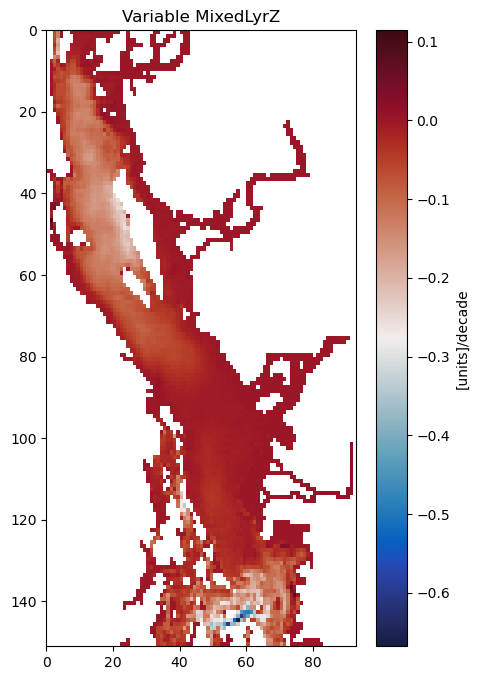

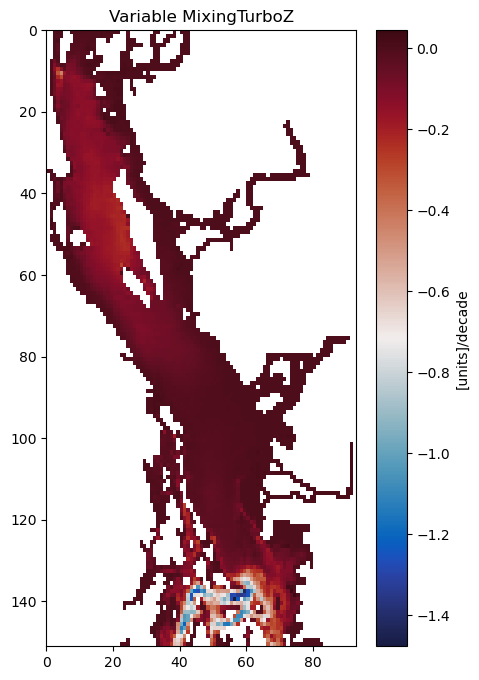

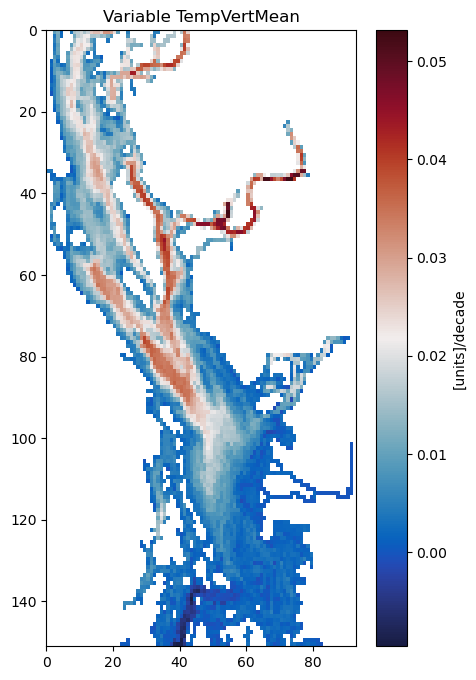

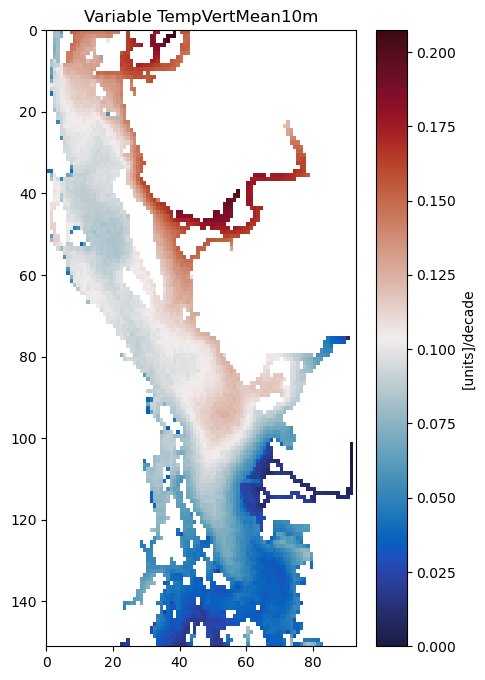

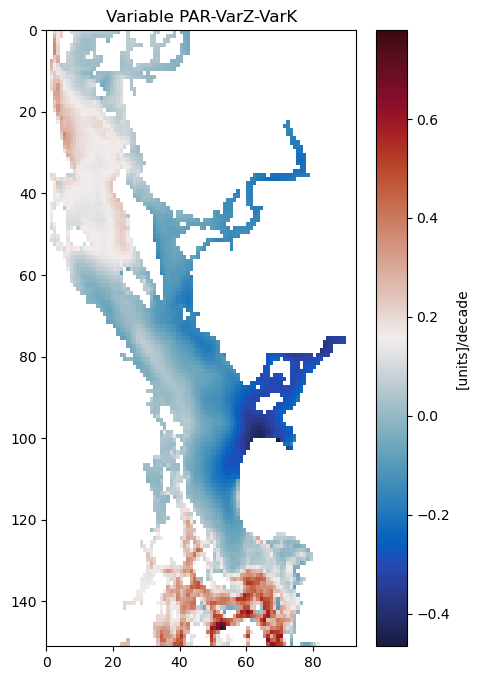

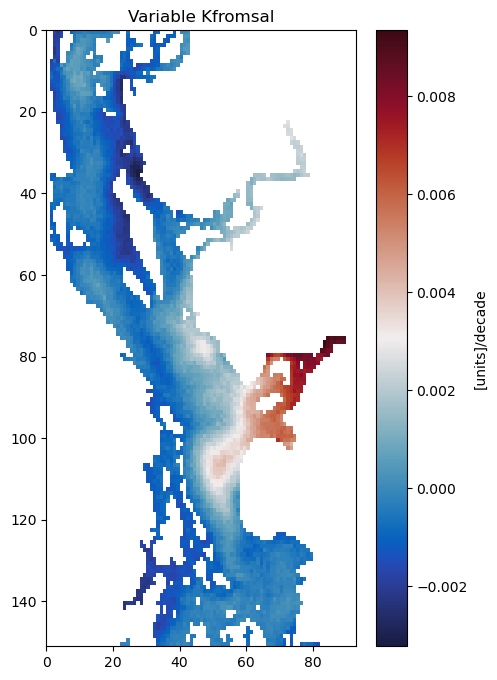

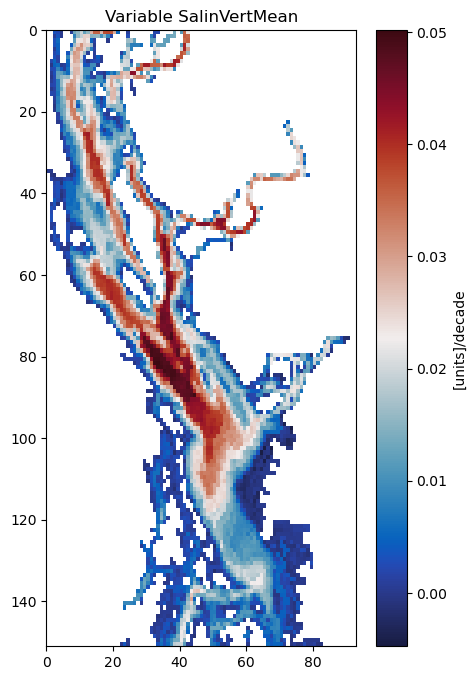

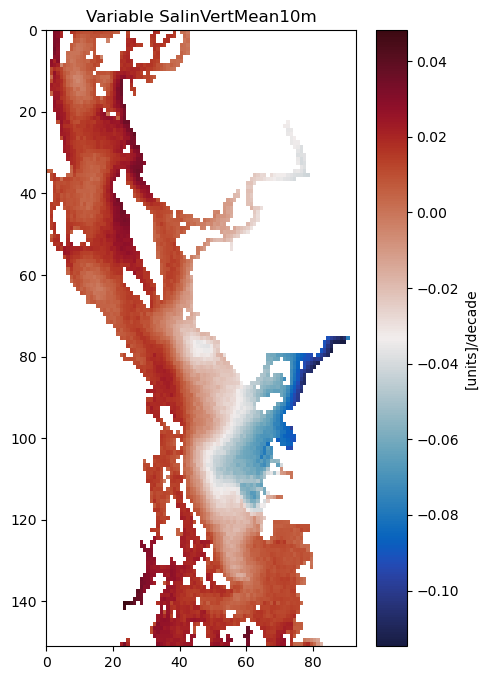

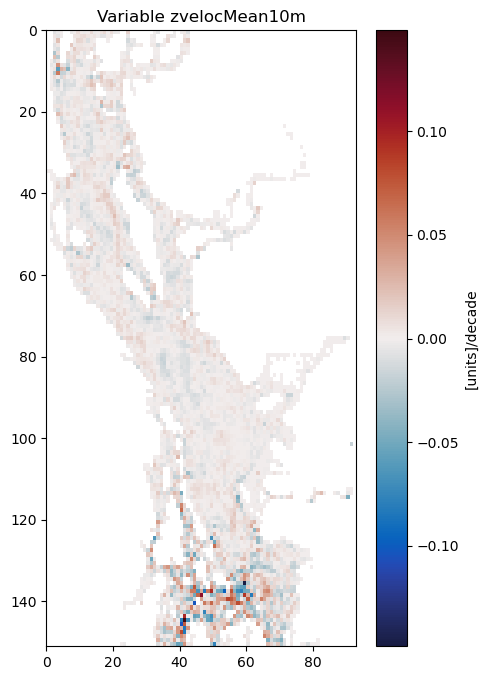

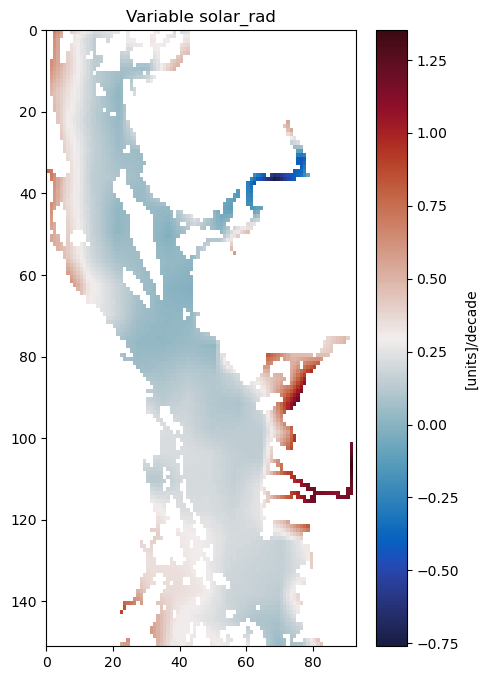

In [4]:
# there appears to be a n-s gradient in temp anom. 
# calc the trend per linear regress trend per decade above but for every cell in the map

# cell-wise analysis
for v in v_f:
    
    #if (v == "TempVertMean10m") | (v == "TempVertMean") | (v == "PAR-VarZ-VarK"):
        
    v1 = ds[v]

    q = v1.groupby('time.month').mean(dim='time') #clim
    anom = (v1.groupby('time.month')-q) #anom

    # convert time to decimal years for regress
    tyr = np.arange(yr_strt,yr_end+1,(1/12)) 
    anom.coords['year'] = ('time', ), tyr
    anom = anom.swap_dims({'time': 'year'})

    # trend through each pixel-slice 
    # https://stackoverflow.com/questions/66594056/linear-regression-on-each-grid-cell-across-time-dim
    lin_fit = anom.polyfit('year', deg=1, skipna=True)
    # y = mx + b
    a = lin_fit.sel(degree=1) # this seems to be slope
    b = lin_fit.sel(degree=0)

    # test visual
    fig, axs = plt.subplots(figsize = (5,8))

    w = plt.pcolormesh(a['polyfit_coefficients']*10, cmap = cm.cm.balance) # * 10 for decade
    #w = plt.pcolormesh(q[6], cmap = cm.cm.balance, vmin=20)
    axs.set_title('Variable {v}'.format(v=v))
    plt.colorbar(w, ax = axs,label='[units]/decade')
    axs.invert_yaxis()



In [19]:
r_squared['polyfit_coefficients']

<xarray.DataArray 'polyfit_coefficients' (row: 151, col: 93)>
array([[       nan,        nan, 0.00385171, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.01309815, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.01451283, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * row      (row) int64 1 2 3 4 5 6 7 8 9 ... 144 145 146 147 148 149 150 151
  * col      (col) int64 1 2 3 4 5 6 7 8 9 10 ... 84 85 86 87 88 89 90 91 92 93

C:\Users\Greig\anaconda3\lib\site-packages\xarray\core\nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
C:\Users\Greig\anaconda3\lib\site-packages\xarray\core\nputils.py:169: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


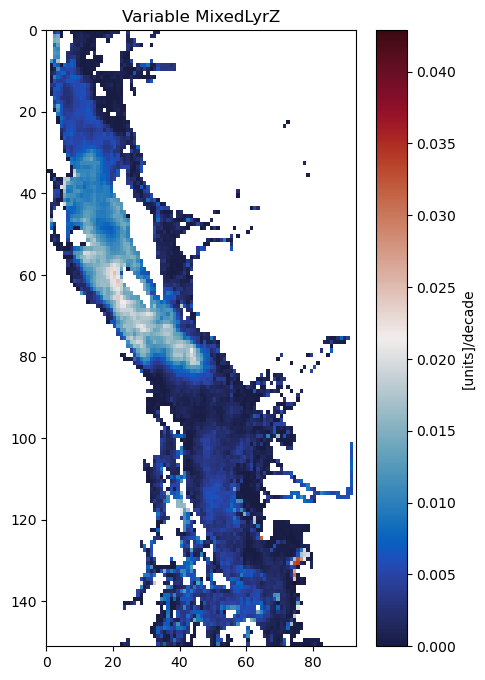

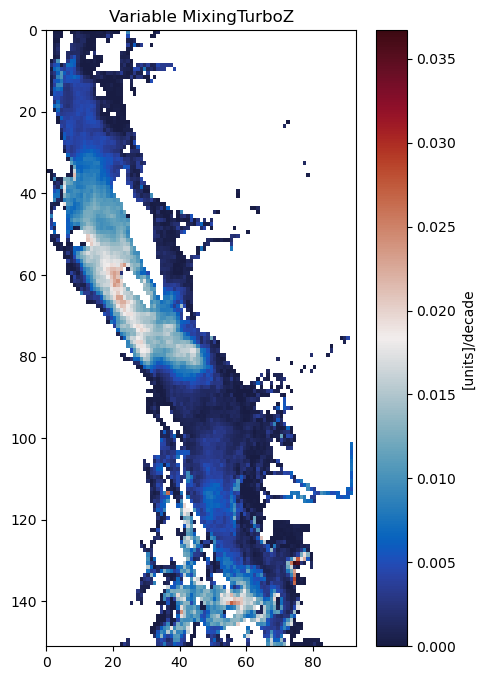

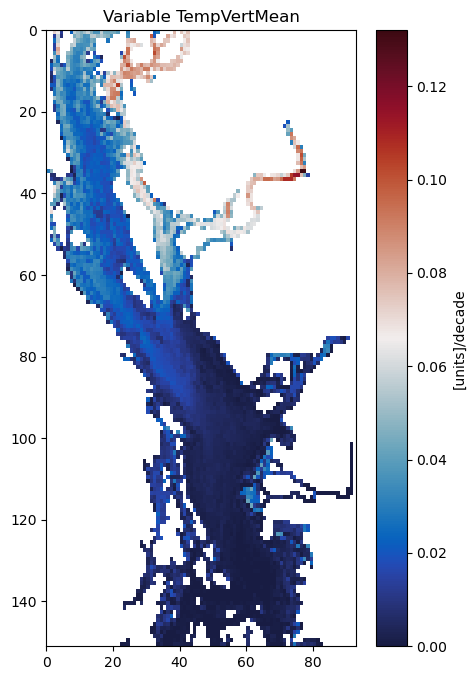

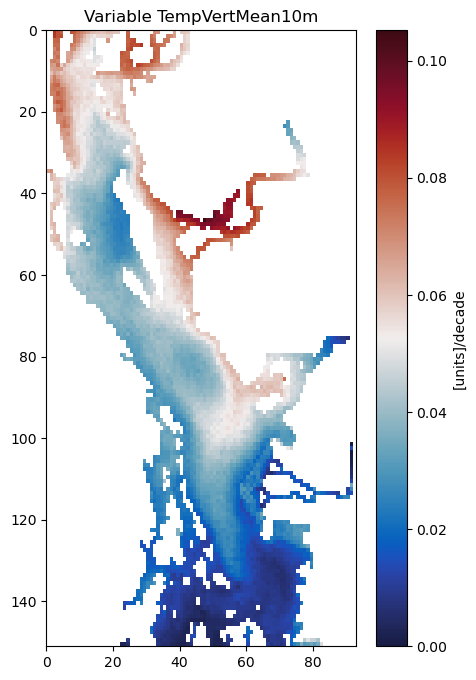

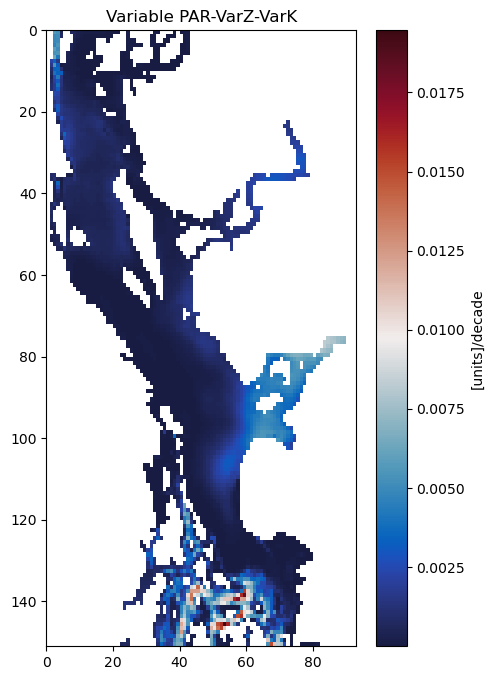

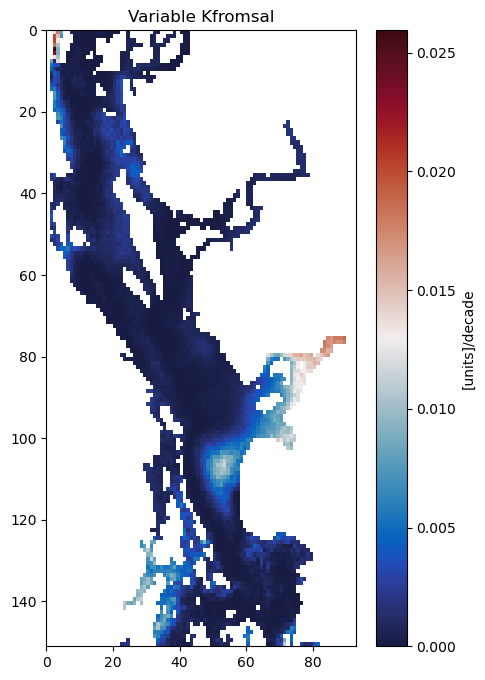

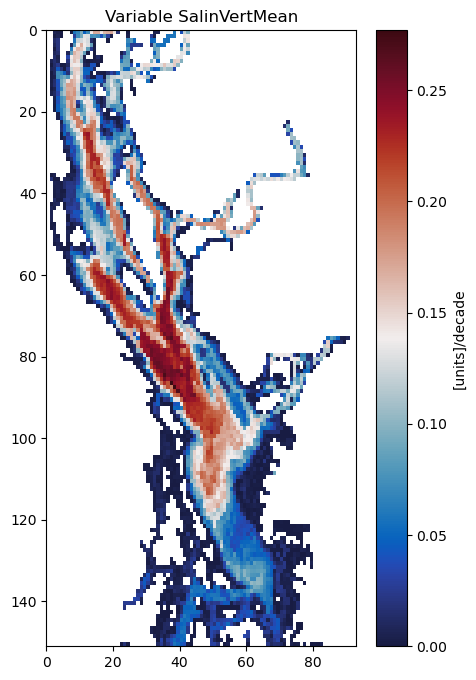

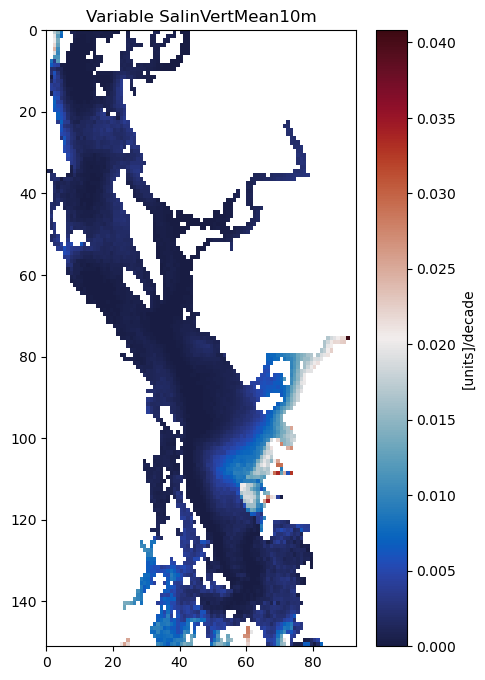

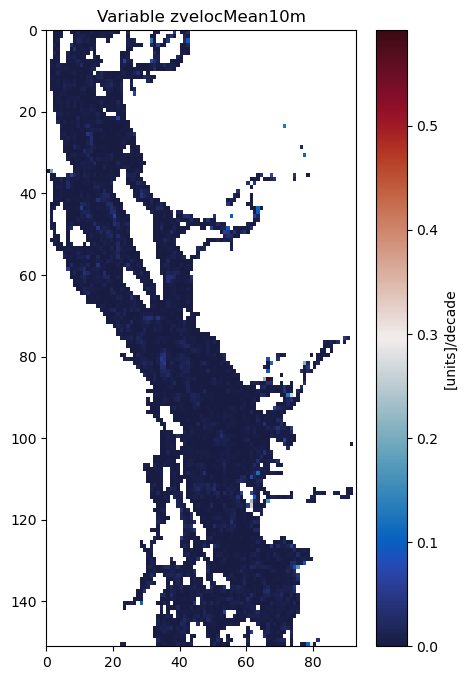

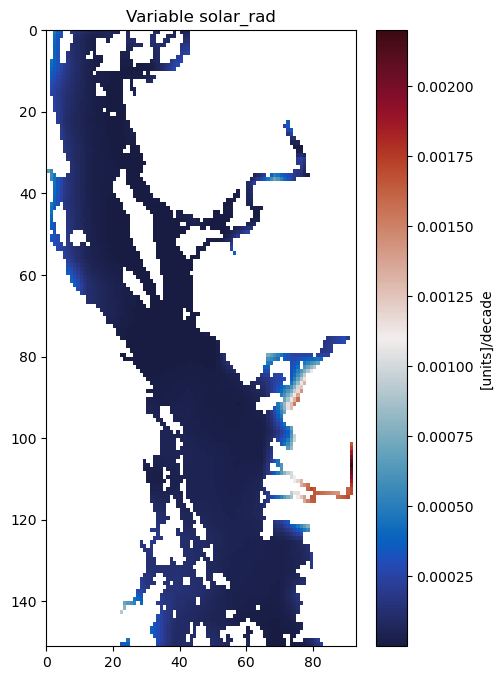

In [25]:
# repetiion of above but experiment with polyval 2023-04-13

# cell-wise analysis
for v in v_f:
    
    #if (v == "TempVertMean10m") | (v == "TempVertMean") | (v == "PAR-VarZ-VarK"):
        
    v1 = ds[v]

    q = v1.groupby('time.month').mean(dim='time') #clim
    anom = (v1.groupby('time.month')-q) #anom

    # convert time to decimal years for regress
    tyr = np.arange(yr_strt,yr_end+1,(1/12)) 
    anom.coords['year'] = ('time', ), tyr
    anom = anom.swap_dims({'time': 'year'})

    # trend through each pixel-slice 
    # https://stackoverflow.com/questions/66594056/linear-regression-on-each-grid-cell-across-time-dim
    lin_fit = anom.polyfit('year', deg=1, skipna=True)
    # y = mx + b
    a = lin_fit.sel(degree=1) # this seems to be slope
    b = lin_fit.sel(degree=0)

    # calculate the predicted values using xarray's polyval function
    trend = xr.polyval(anom['year'], lin_fit)
    
    # variance original data
    var_orig = anom.var(dim='year')
    # calculate the variance of the residuals (unexplained variance)
    var_resid = ((anom - trend)**2).mean(dim='year')
    # calculate the amount of variance explained by the trend
    var_explained = var_orig - var_resid
    # calculate the R-squared value
    r_squared = var_explained / var_orig

    # test visual
    fig, axs = plt.subplots(figsize = (5,8))

    w = plt.pcolormesh(r_squared['polyfit_coefficients'], cmap = cm.cm.balance) # * 10 for decade
    #w = plt.pcolormesh(a['polyfit_coefficients']*10, cmap = cm.cm.balance) # * 10 for decade
    #w = plt.pcolormesh(q[6], cmap = cm.cm.balance, vmin=20)
    axs.set_title('Variable {v}'.format(v=v))
    plt.colorbar(w, ax = axs,label='[units]/decade')
    axs.invert_yaxis()



# to do - try using polyval etc to understand 

# fit a linear trend to the time series using xarray's polyfit function
#pfit = xr.polyfit(ds['time'], ds['data'], 1)

# calculate the predicted values using xarray's polyval function
#trend = xr.polyval(ds['time'], pfit)
# # calculate the variance of the original data
# var_orig = ds['data'].var(dim='time')

# # calculate the variance of the residuals (unexplained variance)
# var_resid = ((ds['data'] - trend)**2).mean(dim='time')

# # calculate the amount of variance explained by the trend
# var_explained = var_orig - var_resid

# # calculate the R-squared value
# r_squared = var_explained / var_orig

# # calculate the 95% confidence interval for the slope parameter
# slope_ci = pfit.polyfit_ci(0.05)['polyfit_coefficients'].values[1,:]

# print('R-squared:', r_squared.values)
# print('95% confidence interval for slope:', slope_ci)

In [131]:
# some results to investigate: 
# - howe sound / plume looks like it is becoming fresher (10 m vert)
# - strange full water col trends for salt and temp that resemble depths when plotted - error? why?
# - K be increasing in Howe and plume
# - most interesting? Mixing and mixed depths trend are only decreasing - no areas increasing. 
#Turbulence and kinetic energy in islands shows strongest negative trend

In [ ]:
# experiments below

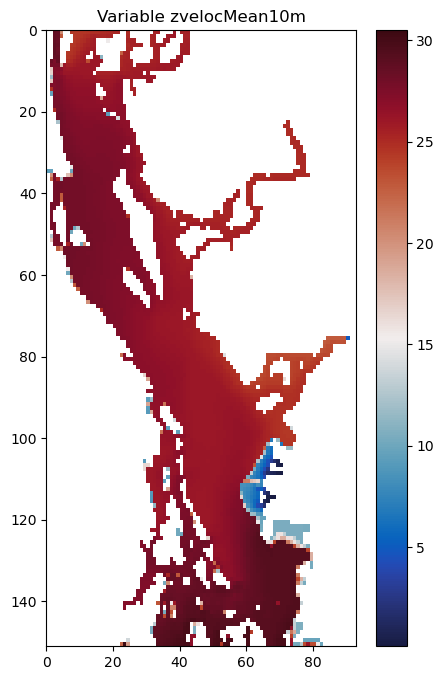

In [53]:
frame = 140

frm_data = v1[frame]

fig, axs = plt.subplots(figsize = (5,8))

w = plt.pcolormesh(frm_data, cmap = cm.cm.balance)
axs.set_title('Variable {v}'.format(v=v))
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

## animation code

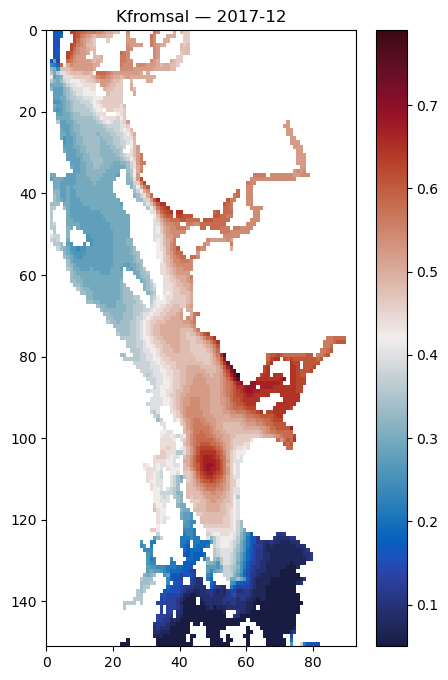

In [129]:
from pathlib import Path
# must download and point matplotlib to .exe
ffmpeg_folder = Path("C://Users//Greig//Documents//GitHub//NEMO-Salish-Sea-2021//code//ffmpeg-2023-04-03-git-6941788d24-essentials_build//bin//ffmpeg.exe")
plt.rcParams['animation.ffmpeg_path'] = ffmpeg_folder


def _update_plot (i, fig, clrmsh):
    #i = (i * 12) + 5 # if only displaying a single month each yr
    i = i + 420
    frm_data = v1[i]
    #clrmsh = plt.pcolormesh(frm_data, cmap = cm.cm.balance, vmin=min_value, vmax=max_value)
    clrmsh = plt.pcolormesh(frm_data, cmap = cm.cm.balance)
    title = u"%s — %s" % (v, str(v1.time[i].values)[:7])
    ax.set_title(title)
    return clrmsh


for v in v_f:
    # PAR-VarZ-VarK
    if (v == "Kfromsal"):
        
        v1 = ds[v]
        frm_data = v1[6]
        #frames = v1.time.size
        frames = 48 #override
        fps=4

        min_value = 0.1 
        max_value = 1.2  

        fig = plt.figure(figsize = (5,8))
        ax = fig.add_subplot()
        ax.invert_yaxis()
        title = u"%s — %s" % (v, str(v1.time[0].values)[:7])
        ax.set_title(title)

        #clrmsh = plt.pcolormesh(frm_data, cmap = cm.cm.balance, vmin=min_value, vmax=max_value)
        clrmsh = plt.pcolormesh(frm_data, cmap = cm.cm.balance)
        plt.colorbar(clrmsh, ax = ax)

        anim = animation.FuncAnimation (fig, _update_plot, fargs= (fig, clrmsh),
                                        frames = frames, interval = 1)

        anim.save('{v}.mp4'.format(v=v), writer=animation.FFMpegWriter(fps=fps))



In [113]:
v1[100]

<xarray.DataArray 'solar_rad' (row: 151, col: 93)>
array([[  nan,   nan, 240.3, ...,   nan,   nan,   nan],
       [  nan,   nan, 242.9, ...,   nan,   nan,   nan],
       [  nan,   nan, 244.3, ...,   nan,   nan,   nan],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])
Coordinates:
    time     datetime64[ns] 1987-05-15
  * row      (row) int32 1 2 3 4 5 6 7 8 9 ... 144 145 146 147 148 149 150 151
  * col      (col) int32 1 2 3 4 5 6 7 8 9 10 ... 84 85 86 87 88 89 90 91 92 93
Attributes:
    description:  solar_rad data

In [264]:
# to do - smooth and / or remove noise

# a quick de-noising fourier transform f(n)
# https://medium.com/swlh/5-tips-for-working-with-time-series-in-python-d889109e676d
def fft_denoiser(x, n_components, to_real=True):
    """Fast fourier transform denoiser.
    
    Denoises data using the fast fourier transform.
    
    Parameters
    ----------
    x : numpy.array
        The data to denoise.
    n_components : int
        The value above which the coefficients will be kept.
    to_real : bool, optional, default: True
        Whether to remove the complex part (True) or not (False)
        
    Returns
    -------
    clean_data : numpy.array
        The denoised data.
        
    References
    ----------
    .. [1] Steve Brunton - Denoising Data with FFT[Python]
       https://www.youtube.com/watch?v=s2K1JfNR7Sc&ab_channel=SteveBrunton
    
    """
    n = len(x)
    
    # compute the fft
    fft = np.fft.fft(x, n)
    
    # compute power spectrum density
    # squared magnitud of each fft coefficient
    PSD = fft * np.conj(fft) / n
    
    # keep high frequencies
    _mask = PSD > n_components
    fft = _mask * fft
    
    # inverse fourier transform
    clean_data = np.fft.ifft(fft)
    
    if to_real:
        clean_data = clean_data.real
    
    return clean_data



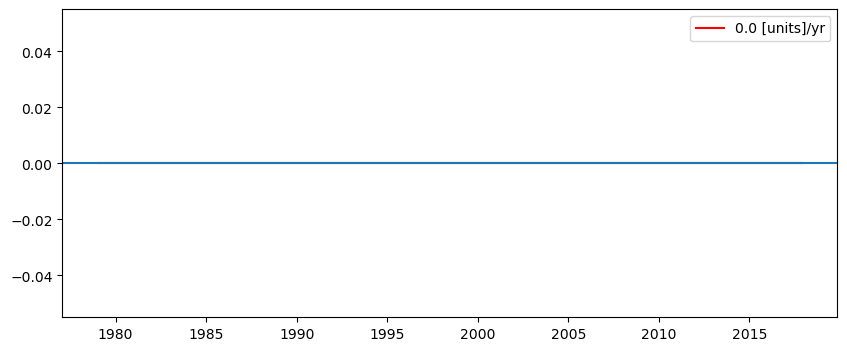

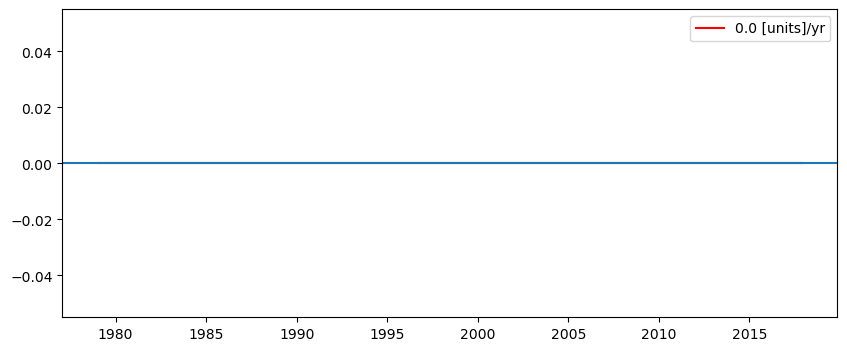

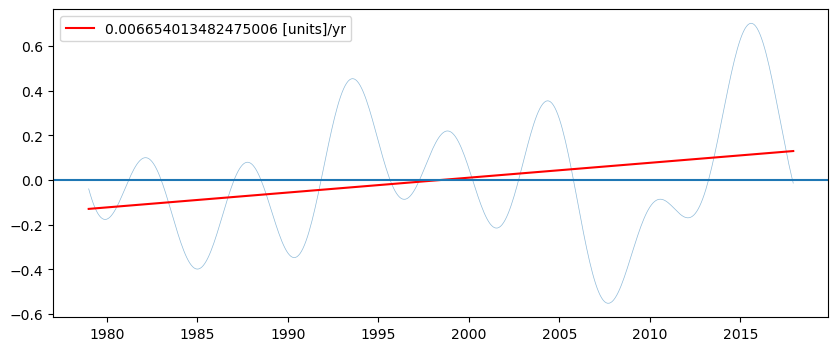

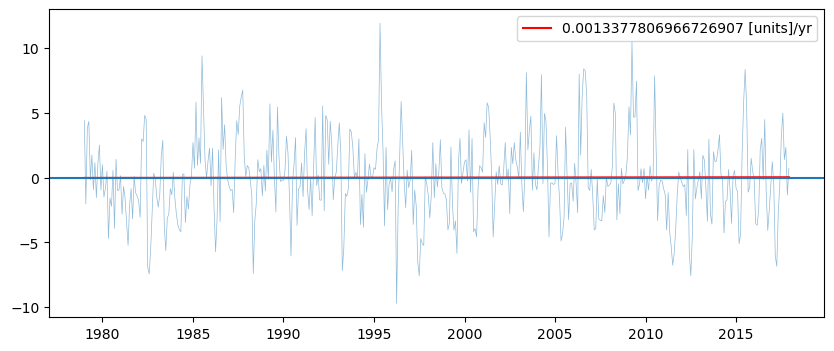

In [306]:
# not working don't trust


# to do: subregional look
for v in v_f:
    v1 = ds2[v]
    clim = v1.groupby('time.month').mean(dim='time')
    anom = (v1.groupby('time.month')-clim).T
    mean_anom = anom.isel(row = (anom.row > 40) & (anom.row < 100)).mean(dim = 'row')
    tyr = np.arange(yr_strt,yr_end+1,(1/12)) # simple x labels
    
    # ==== de-noiser ====
    n_components = 2
    mean_anom_smth = fft_denoiser(mean_anom, n_components, to_real=True)    
    
    fig, axs = plt.subplots(figsize = (10,4))
    
    # orig
    #axs.plot(tyr, mean_anom.values,linewidth = 0.5, alpha = 0.5)
    # smoothed
    axs.plot(tyr, mean_anom_smth,linewidth = 0.5, alpha = 0.5)
    
    # trend
    x = tyr[~np.isnan(mean_anom_smth)]
    y = mean_anom_smth[~np.isnan(mean_anom_smth)]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    
    
    #axs.plot(x, y, '.', label='Original data', markersize=2)
    axs.plot(x, m*x + c, 'r', label=f'{m} [units]/yr')
    axs.legend(loc = 'best')
    axs.axhline(y=0)

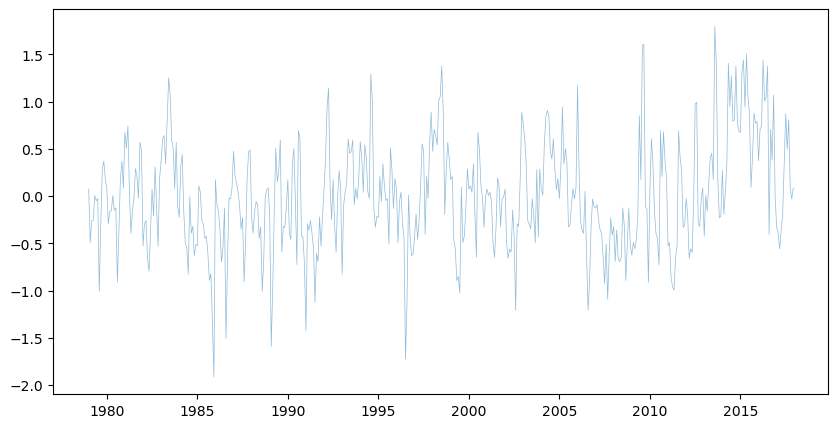

In [543]:
# test visual
fig, axs = plt.subplots(figsize = (10,5))
axs.plot(tyr, anom[:,60,30],linewidth = 0.5, alpha = 0.5)

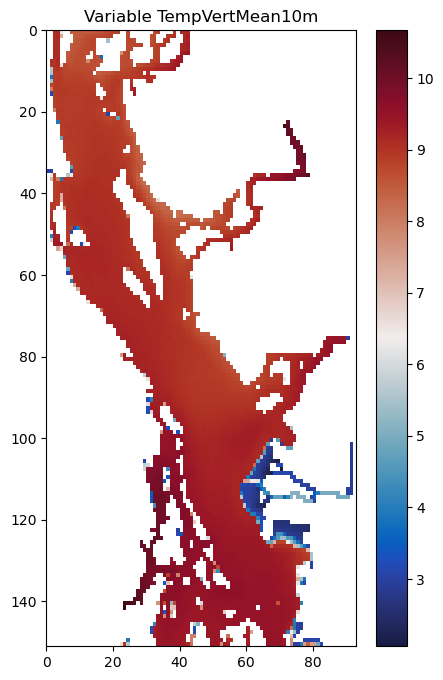

In [551]:
# test visual
fig, axs = plt.subplots(figsize = (5,8))

v="TempVertMean10m"
w = plt.pcolormesh(q[10,:,:], cmap = cm.cm.balance)
axs.set_title('Variable {v}'.format(v=v))
plt.colorbar(w, ax = axs)
axs.invert_yaxis()

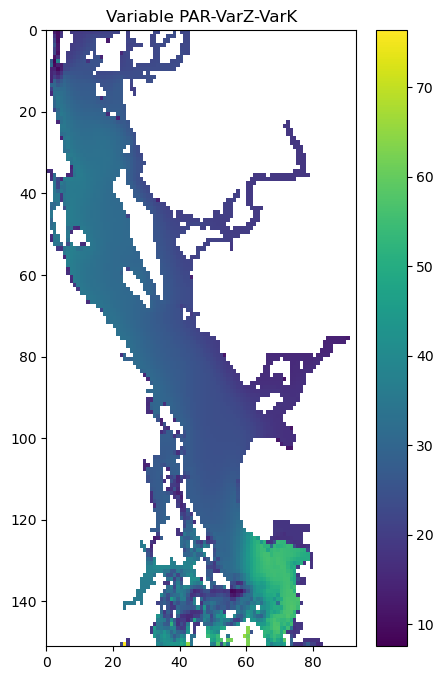

In [511]:
# test visual
fig, axs = plt.subplots(figsize = (5,8))

# mon,row,col
q1 =  q[7,:,:]
#q1 =  anom[120,:,:]
    
w = plt.pcolormesh(q1)
axs.set_title('Variable {v}'.format(v=v))
plt.colorbar(w, ax = axs)
axs.invert_yaxis()
